In [14]:
import numpy as np
import matplotlib.pyplot as plt

tau= 1
poissons_ratio = 0.20
E = 0.2 
Initial_stress = 200     #MPa
Inner_radius = 5 
outer_radius = 20
Epsilon = 0              #Gauss point
delta_u = 1

n = 10                   
Shape_func = np.array([1/2*(1-Epsilon),1/2*(1+Epsilon)])
mu = E/(2*(1+poissons_ratio))
Lambda=poissons_ratio*E/((1-2*poissons_ratio)*(1+poissons_ratio))
volumetric_strain = -0.005



#displacement_1 = 1/3*tau*volumetric_strain*Inner_radius
C = np.array([[Lambda+2*mu,Lambda,Lambda],
              [Lambda,Lambda+2*mu,Lambda],
              [Lambda,Lambda,Lambda+2*mu]])


coordinate = np.linspace(Inner_radius,outer_radius,n+1)
Global_K = np.zeros((n+1,n+1))                       # Zero matrix of order (n+1,n+1) for adding elemental stiffness


#Global_displacement = np.zeros((n+1,1))
d = np.linspace(0,(1/3*tau*(-volumetric_strain)*Inner_radius),n+1).reshape((n+1,1)) #Initial guess
Global_displacement = np.flip(d,0)
Global_F_ext = np.zeros((n+1,1))                     # Zero matrix of order (n+1,1) to add force matrix



for i in range(len(coordinate)-1):
    def element_routine(coordinate):
        Derivative_N = np.array([-1/2,1/2])
        Jacobian = Derivative_N@np.array([[coordinate[i]],
                                          [coordinate[i+1]]])
        J_inv = np.asscalar(1/Jacobian)
        
        B = np.array([[-1/2*J_inv,1/2*J_inv],
                      [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                      [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])
    
        B_T = np.transpose(B)
        Element_stiffness = 2*(B_T@(material_routine(Lambda,mu))@B)*Jacobian*((coordinate[i]+coordinate[i+1])/2)**2
        return Element_stiffness,J_inv
    
    
        
    def material_routine(Lambda,mu):
        return C
 
    #Assignmnet matrix
    Ae = np.zeros((2,n+1))
    Ae[0,i]=1                                            # [0,n-1]=1 [1,n]=1
    Ae[1,i+1]  =1
    AeT = np.transpose(Ae)
    
    Ke,J_i = element_routine(coordinate)
    #Global stiffness matrix
    K=AeT@Ke@Ae                                          # Stiffness matrix  of each element after transformation
    Global_K = np.add(Global_K,K)                        # Global stiffnes matrix
    
    
    #External force calculation
    sigma_rr = 2*mu*J_i*((-Global_displacement[i]+Global_displacement[i+1])/2)+Lambda*tau*volumetric_strain
  
    Fe_ext = np.array([[-np.asscalar(sigma_rr)*coordinate[i]**2],
                       [np.asscalar(sigma_rr)*coordinate[i+1]**2]])
    
    F_ext = np.dot(AeT,Fe_ext)                           # Force vector of each element after transformation
    Global_F_ext=np.add(Global_F_ext,F_ext)              # Global F matrix
    Global_F_ext[-1]=0                                   # Global F matrix
    
 

    
#Newton Raphson method
while np.linalg.norm(delta_u)>(0.005*np.linalg.norm(Global_displacement)):
    
    G_matrix = Global_K@Global_displacement - Global_F_ext
    delta_u = np.linalg.inv(Global_K)@G_matrix
    Global_displacement = Global_displacement - delta_u
print(Global_displacement)                     



[[0.00563047]
 [0.00338934]
 [0.00230065]
 [0.00169736]
 [0.00133363]
 [0.00110165]
 [0.00094809]
 [0.0008441 ]
 [0.00077299]
 [0.00072453]
 [0.00069218]]


[0.00833333 0.00493097 0.00325521 0.0023084  0.00172176 0.00133333
 0.00106293 0.00086715 0.00072088 0.00060872 0.00052083]


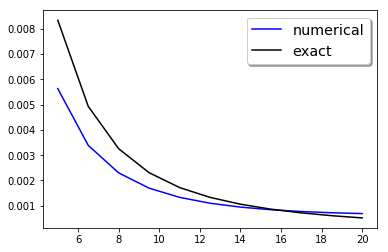

In [17]:
u_elastic = ((Inner_radius)**3*(-volumetric_strain)*tau)/(3*(coordinate)**2)
print(u_elastic)
fig,ax = plt.subplots()
ax.plot(coordinate,Global_displacement,'b',label='numerical')
ax.plot(coordinate,u_elastic,'k',label='exact')
ax.legend(loc='upper right', shadow=True, fontsize='x-large')